In [1]:
!nvidia-smi

Thu May 26 22:15:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:47:00.0 Off |                   On |
| N/A   37C    P0    79W / 275W |                  N/A |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+

+-----------------------------------------------------------------------------+
| MIG d

In [2]:
import torch

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split, Dataset

%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
all_data = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [5]:
idx2cls = {
    0:'airplane',
    1:'automobile',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
}

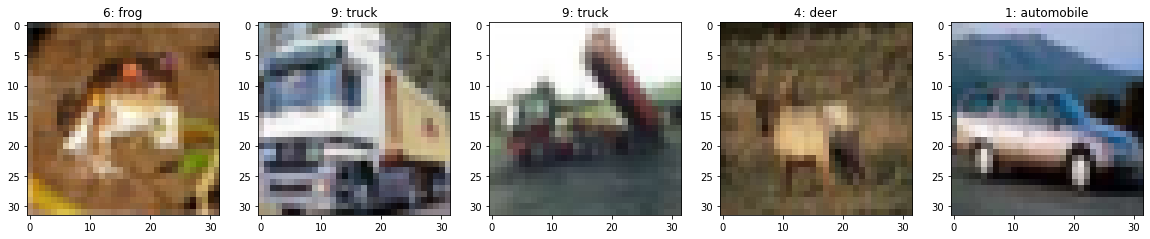

In [6]:
plt.figure(figsize=(20,10))
for idx in range(5):
    plt.subplot(1, 5, idx+1)
    img = all_data[idx][0].numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    label = all_data[idx][1]
    plt.title(f'{label}: {idx2cls[label]}')

In [7]:
meanRGB = [np.mean(img.numpy(), axis=(1, 2)) for img,_ in all_data]
stdRGB = [np.std(img.numpy(), axis=(1, 2)) for img,_ in all_data]

In [8]:
print(meanRGB[0:5])
print(stdRGB[0:5])

[array([0.5537454 , 0.41215533, 0.25112593], dtype=float32), array([0.5105852 , 0.51123625, 0.51167667], dtype=float32), array([0.52346814, 0.53000927, 0.51994103], dtype=float32), array([0.39207646, 0.32658547, 0.2251532 ], dtype=float32), array([0.36086857, 0.40157017, 0.45491347], dtype=float32)]
[array([0.15946537, 0.1663897 , 0.16018412], dtype=float32), array([0.24310777, 0.23616177, 0.23211895], dtype=float32), array([0.3277734 , 0.32357776, 0.31985202], dtype=float32), array([0.14899625, 0.12453357, 0.09754382], dtype=float32), array([0.23193689, 0.22035787, 0.24969089], dtype=float32)]


In [9]:
# 모든 이미지 픽셀값을 각 RGB의 평균과 표준편차로 정규화 해주기 위함.
meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

In [10]:
print(f"Mean- R:{meanR:.6f}, G:{meanG:.6f}, B:{meanB:.6f}")
print(f"Std - R:{stdR:.6f}, G:{stdG:.6f}, B:{stdB:.6f}")

Mean- R:0.491400, G:0.482158, B:0.446531
Std - R:0.202202, G:0.199315, B:0.200863


In [11]:
# custom dataset에 반드시 정의해야 하는 method
# init: 변수 설정
# len: 데이터의 갯수를 리턴
# getitem(self, index): 만든 리스트의 index에 해당하는 샘플을 불러와 전처리 후 tensor형으로 리턴
class CustomSubset(Dataset):
    def __init__(self, dataset, transform=None):
        super(CustomSubset, self).__init__()
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

In [12]:
transform = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        # 논문에 (224,224)로 나와있지만, 첫 conv layer이후 (55,55) 차원을 따르지 않아 (227,227)로 변경.
        transforms.RandomResizedCrop((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(meanR, meanG, meanB), std=(stdR, stdG, stdB))
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(meanR, meanG, meanB), std=(stdR, stdG, stdB))
    ])
}

In [13]:
train_ratio = 0.8
train_data_len = int(len(all_data) * train_ratio)
valid_data_len = len(all_data) - train_data_len

train_data, valid_data = random_split(all_data, [train_data_len, valid_data_len])

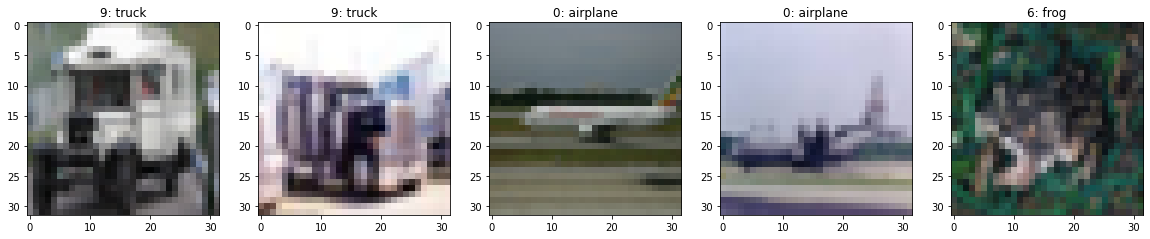

In [14]:
plt.figure(figsize=(20, 10))
for idx in range(5):
    plt.subplot(1, 5, idx+1)
    img = train_data[idx][0].numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    label = train_data[idx][1]
    plt.title(f"{label}: {idx2cls[label]}")

In [15]:
all_data.transform = None
train_data = CustomSubset(train_data, transform['train'])
valid_data = CustomSubset(valid_data, transform['test'])
test_data = CIFAR10(root='./data', train=False, download=True, transform=transform['test'])

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


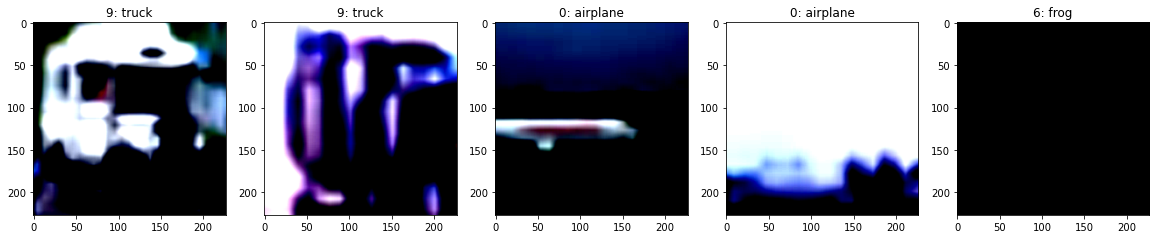

In [16]:
plt.figure(figsize=(20, 10))
for idx in range(5):
    plt.subplot(1, 5, idx+1)
    img = train_data[idx][0].numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    label = train_data[idx][1]
    plt.title(f"{label}: {idx2cls[label]}")

In [17]:
class MyAlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(MyAlexNet, self).__init__()
        self.convnet = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Layer 2
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Layer 3
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 4
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 5
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.fc = nn.Sequential(
            # Layer 6
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256*6*6, out_features=4096),
            nn.ReLU(),

            # Layer 7
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),

            # Layer 8
            nn.Linear(in_features=4096, out_features=num_classes)
        )

        self.init_weights_and_bias()

    def init_weights_and_bias(self):
        conv_idx = 1
        fc_idx = 1
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                # 논문에 따라 weight initialization은 mean=0, std=0.01인 가우시안 분포로 초기화
                nn.init.normal_(layer.weight, mean=0, std=0.01)                
                # 논문에 따라 1,3 번째 conv layer의 bias는 0으로 초기화
                # 논문에 따라 2,4,5 번째 conv layer의 bias는 1으로 초기화
                if conv_idx == 1 or conv_idx == 3:
                    nn.init.constant_(layer.bias, 0)
                else:
                    nn.init.constant_(layer.bias, 0.1)
                    # bias를 setting하는 과정에서 2012년도 기준 caffe 프레임워크를 고려하여 1이 아닌 0.1로 세팅함.
                    # bias를 1로 두면 학습이 이루어지지 않음.
                conv_idx += 1
            elif isinstance(layer, nn.Linear):
                # 논문에 따라 weight initialization은 mean=0, std=0.01인 가우시안 분포로 초기화
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                # 논문에 따라 hidden fc layer의 bias는 1로 초기화
                if fc_idx <= 2:
                    nn.init.constant_(layer.bias, 0.1)
                else:
                    nn.init.constant_(layer.bias, 0)
                fc_idx += 1

    def forward(self, x):
        x = self.convnet(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [18]:
batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [19]:
model = MyAlexNet(num_classes=10)

# softmax와 crossentropy가 합쳐져 있기 때문에, 위 모델의 마지막에 softmax를 해주지 않아도 된다.
criterion = nn.CrossEntropyLoss()

momentum = 0.9
weight_decay = 0.0005
init_lr = 0.01

# pytorch 공식 문서에서는 model을 GPU로 보낼 것이라면, 해당 model에 대한 optimizer를 만들기 전에 먼저 GPU 세팅을 하라고 함.
model = model.to(device)
criterion = criterion.to(device)

optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum, weight_decay=weight_decay)
# 성능 향상이 없을 때, learning rate를 감소시키는 스케줄러
# validation loss를 지표로 사용할 것이므로 mode='min'으로 설정한다 (metric이 감소를 멈출 때)
# 논문에서 학슴 도중 총 3번 감소하였으므로, min_lr은 0.00001로 설정 하였으며, patience는 임의의 값
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=5, min_lr=0.00001, verbose=True)


In [20]:
print(model)

MyAlexNet(
  (convnet): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): 

In [21]:
def train(model, epochs, train_loader, valid_loader, criterion, optimizer, scheduler, print_log=True, early_stop=None, model_path='myalexnet.pth'):
    train_logs = {'Loss': [], 'Accuracy': []}
    valid_logs = {'Loss': [], 'Accuracy': []}
    patience = 0
    best_acc = -np.inf
    for epoch in range(epochs):
        train_loss = 0
        valid_loss = 0
        train_acc = 0
        valid_acc = 0
        # train step
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            # 모델 예측
            pred = model(data)
            # loss 계산
            loss = criterion(pred, target)
            # gradient를 0으로 초기화
            optimizer.zero_grad()
            # loss 미분하여 gradient 계산
            loss.backward()
            # Weight, bias update
            optimizer.step()
            # 각 minibatch의 수만큼 loss를 곱해서 더해준다 (이후 전체 batch의 평균 loss를 구하기 위함)
            train_loss += loss.item() * data.size(0)
            # 각 minibatch의 모든 data의 예측값과 정답 label을 비교하여 올바른 예측만 더함
            train_acc += torch.sum(pred.argmax(1) == target).item()
        
        # 한 epoch의 평균 train_loss, train_accuracy를 구해 log에 추가
        train_loss /= len(train_data)
        train_acc /= len(train_data)
        train_logs['Loss'].append(train_loss)
        train_logs['Accuracy'].append(train_acc)

        if print_log:
            print(f"Training   Epoch {epoch+1} - Loss: {train_loss:.8f}, Accuracy: {train_acc*100:.4f}%")
        
        # validation step
        # 학습을 진행하지 않음
        with torch.no_grad():
            # evaluation 과정에서 사용하지 않을 layer들의 전원을 끈다
            # 대표적으로 dropout, batch_normalization 등이 있음
            model.eval()
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                pred = model(data)
                loss = criterion(pred, target)
                valid_loss += loss.item() * data.size(0)
                valid_acc += torch.sum(pred.argmax(1) == target).item()
            
            valid_loss /= len(valid_data)
            valid_acc /= len(valid_data)
            valid_logs['Loss'].append(valid_loss)
            valid_logs['Accuracy'].append(valid_acc)

            if print_log:
                print(f"Validation Epoch {epoch+1} - Loss: {valid_loss:.8f}, Accuracy: {valid_acc*100:.4f}%")
        
            # best model 갱신
            if valid_acc > best_acc:
                best_acc = valid_acc
                torch.save(model.state_dict(), model_path)
                if early_stop is not None:
                    patience = 0
            elif early_stop is not None:
                patience += 1
                if patience == early_stop:
                    print('Training finished by early stopping')
                    return train_logs, valid_logs
            
            # lr scheduler
            scheduler.step(valid_loss)


    return train_logs, valid_logs


In [22]:
from datetime import datetime

start_time = datetime.now()
print(start_time)

2022-05-26 22:16:13.644843


In [23]:
epochs = 90

train_logs, valid_logs = train(model=model,
                              epochs=epochs,
                              train_loader=train_loader,
                              valid_loader=valid_loader,
                              criterion=criterion,
                              optimizer=optimizer,
                              scheduler=scheduler,
                              early_stop=10) # early_stop는 임의의 값

Training   Epoch 1 - Loss: 2.22110866, Accuracy: 14.8050%
Validation Epoch 1 - Loss: 1.97922838, Accuracy: 24.9100%
Training   Epoch 2 - Loss: 1.93997149, Accuracy: 26.7625%
Validation Epoch 2 - Loss: 1.76424580, Accuracy: 34.2000%
Training   Epoch 3 - Loss: 1.77049886, Accuracy: 33.6375%
Validation Epoch 3 - Loss: 1.52924382, Accuracy: 43.2600%
Training   Epoch 4 - Loss: 1.68683510, Accuracy: 37.1675%
Validation Epoch 4 - Loss: 1.36537609, Accuracy: 49.4100%
Training   Epoch 5 - Loss: 1.60315079, Accuracy: 40.9950%
Validation Epoch 5 - Loss: 1.34272389, Accuracy: 51.9700%
Training   Epoch 6 - Loss: 1.52587177, Accuracy: 44.1600%
Validation Epoch 6 - Loss: 1.20961307, Accuracy: 57.1800%
Training   Epoch 7 - Loss: 1.44276483, Accuracy: 47.7850%
Validation Epoch 7 - Loss: 1.10629059, Accuracy: 60.2800%
Training   Epoch 9 - Loss: 1.31202287, Accuracy: 53.1325%
Validation Epoch 9 - Loss: 1.02817080, Accuracy: 63.4600%
Training   Epoch 10 - Loss: 1.25909582, Accuracy: 54.6475%
Validation Ep

Training   Epoch 72 - Loss: 0.46920040, Accuracy: 83.7800%
Validation Epoch 72 - Loss: 0.32254108, Accuracy: 89.5100%
Training   Epoch 73 - Loss: 0.45770614, Accuracy: 84.1250%
Validation Epoch 73 - Loss: 0.32655360, Accuracy: 89.3800%
Training   Epoch 74 - Loss: 0.46727724, Accuracy: 83.5925%
Validation Epoch 74 - Loss: 0.32541097, Accuracy: 89.6300%
Training   Epoch 75 - Loss: 0.45798618, Accuracy: 84.1800%
Validation Epoch 75 - Loss: 0.32520805, Accuracy: 89.4600%
Validation Epoch 76 - Loss: 0.32875370, Accuracy: 89.5500%
Training   Epoch 77 - Loss: 0.46236517, Accuracy: 83.9875%
Validation Epoch 77 - Loss: 0.32177303, Accuracy: 89.7800%
Training   Epoch 78 - Loss: 0.45793856, Accuracy: 83.9375%
Validation Epoch 78 - Loss: 0.33202834, Accuracy: 89.3300%
Training   Epoch 79 - Loss: 0.45977077, Accuracy: 84.0625%
Validation Epoch 79 - Loss: 0.32489276, Accuracy: 89.6000%
Training   Epoch 80 - Loss: 0.45719729, Accuracy: 84.1675%
Validation Epoch 80 - Loss: 0.32041722, Accuracy: 89.540

In [24]:
end_time = datetime.now()
print(end_time)
# 약 5시간의 학습 시간 소모

2022-05-27 03:38:22.659335


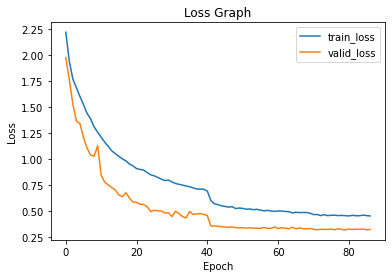

In [25]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot([i for i in range(len(train_logs['Loss']))],train_logs['Loss'],label='train_loss')
plt.plot([i for i in range(len(valid_logs['Loss']))],valid_logs['Loss'],label='valid_loss')
plt.legend()
plt.title("Loss Graph")
plt.show()

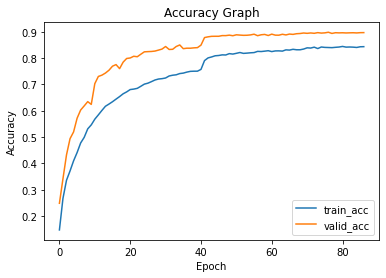

In [26]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot([i for i in range(len(train_logs['Accuracy']))],train_logs['Accuracy'],label='train_acc')
plt.plot([i for i in range(len(valid_logs['Accuracy']))],valid_logs['Accuracy'],label='valid_acc')
plt.legend()
plt.title("Accuracy Graph")
plt.show()
# learning rate가 조정 될 때마다 그래프 폭 크게 변화.

In [27]:
model.load_state_dict(torch.load('myalexnet.pth'))
model = model.to(device)

In [28]:
def test(model, criterion, test_loader):
    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            pred = model(data)
            loss = criterion(pred, target)
            test_loss += loss.item() * data.size(0)
            test_acc += torch.sum(pred.argmax(1) == target).item()
        test_loss /= len(test_data)
        test_acc /= len(test_data)
    return test_loss, test_acc
            

In [29]:
test_loss, test_acc = test(model=model,
                           criterion=criterion,
                           test_loader=test_loader)

In [30]:
# test data에 대해 좋은 성능을 보임
print(f"Test - Loss: {test_loss:.8f}, Accuracy: {test_acc*100:.4f}%")

Test - Loss: 0.33921651, Accuracy: 89.0900%


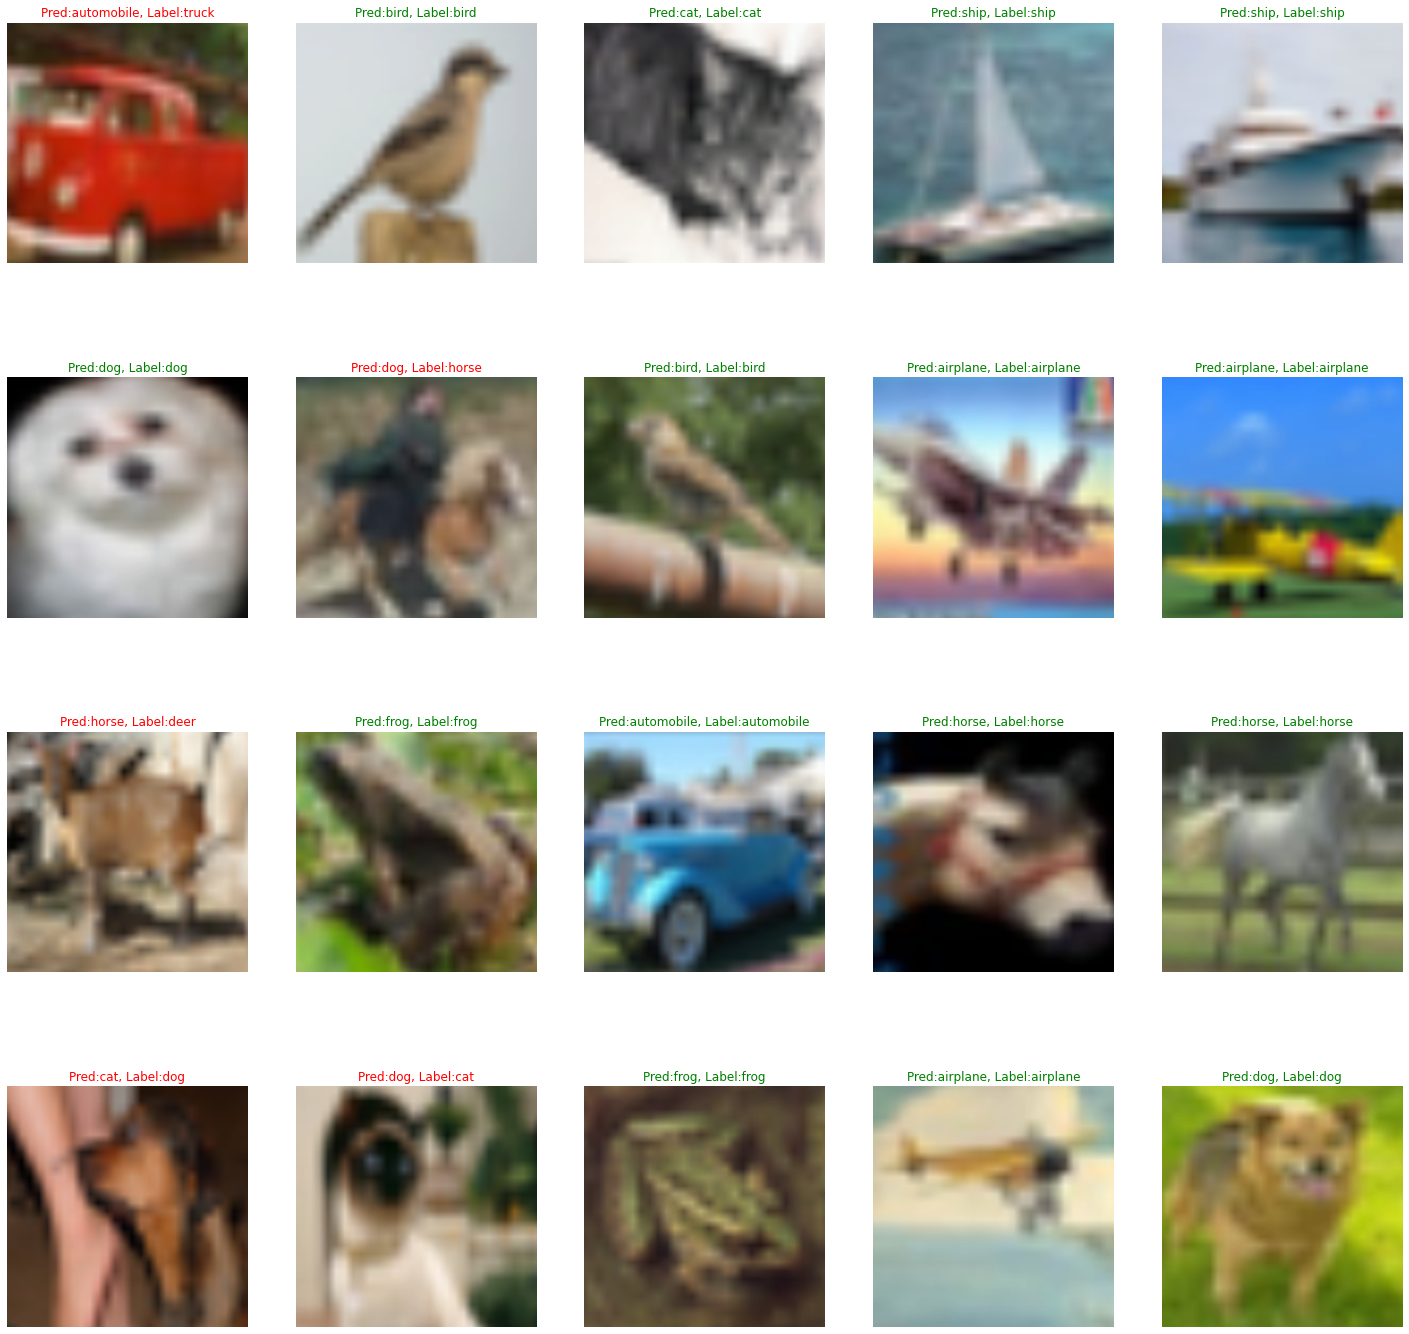

In [31]:
unNormalizeTransform = transforms.Compose([
    transforms.Normalize(mean=[-meanR/stdR, -meanG/stdG, -meanB/stdB],
                         std=[1.0/stdR, 1.0/stdG, 1.0/stdB]),
    transforms.ToPILImage()
])

fig=plt.figure(figsize=(25, 25))
for i, sample_idx in enumerate(np.random.choice(len(test_data), size=20, replace=False)):
    plt.subplot(4, 5, i+1)
    img = unNormalizeTransform(test_data[sample_idx][0])
    pred = model(test_data[sample_idx][0].unsqueeze(0).to(device))
    predict = idx2cls[pred.argmax().item()]
    label = idx2cls[test_data[sample_idx][1]]
    plt.title("Pred:{}, Label:{}".format(predict, label),
             color=("green" if predict == label else "red"))
    plt.axis('off')
    plt.imshow(img)